In [8]:
import pandas as pd 
df = pd.read_csv("Data/syn_fin_ds.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:

df.shape


(6362620, 11)

In [21]:
!pip install seaborn

# Obs  
- approximately 6.3 Million Rows (instances)
- 11 atrributes , 4 should be removed , effectively  7 attributes 

# Pre Processing and EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
# If C -> Customer Account 
# If M -> Merchant Account 
def first_letter(name: str) -> str:
    return name[0:1]

dest_first = df["nameDest"].apply(first_letter)
orig_first = df["nameOrig"].apply(first_letter)

print(len(dest_first.value_counts()))
print(len(orig_first.value_counts()))
df["nameDest"] = dest_first
df["nameOrig"] = orig_first

2
1


In [12]:
# Drop Cols for the oldbalanceOrg , newbalanceOrig , oldbalanceDest , newbalanceDest -> Data Leakage 
# The fraud transactions are cancelled 
df.drop(columns=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"],inplace=True)
df.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C,M,0,0
1,1,PAYMENT,1864.28,C,M,0,0
2,1,TRANSFER,181.00,C,C,1,0
3,1,CASH_OUT,181.00,C,C,1,0
4,1,PAYMENT,11668.14,C,M,0,0


In [13]:
# step means the time of the day transaction occured 
df["step"].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
725        4
655        4
246        4
662        2
112        2
Name: count, Length: 743, dtype: int64

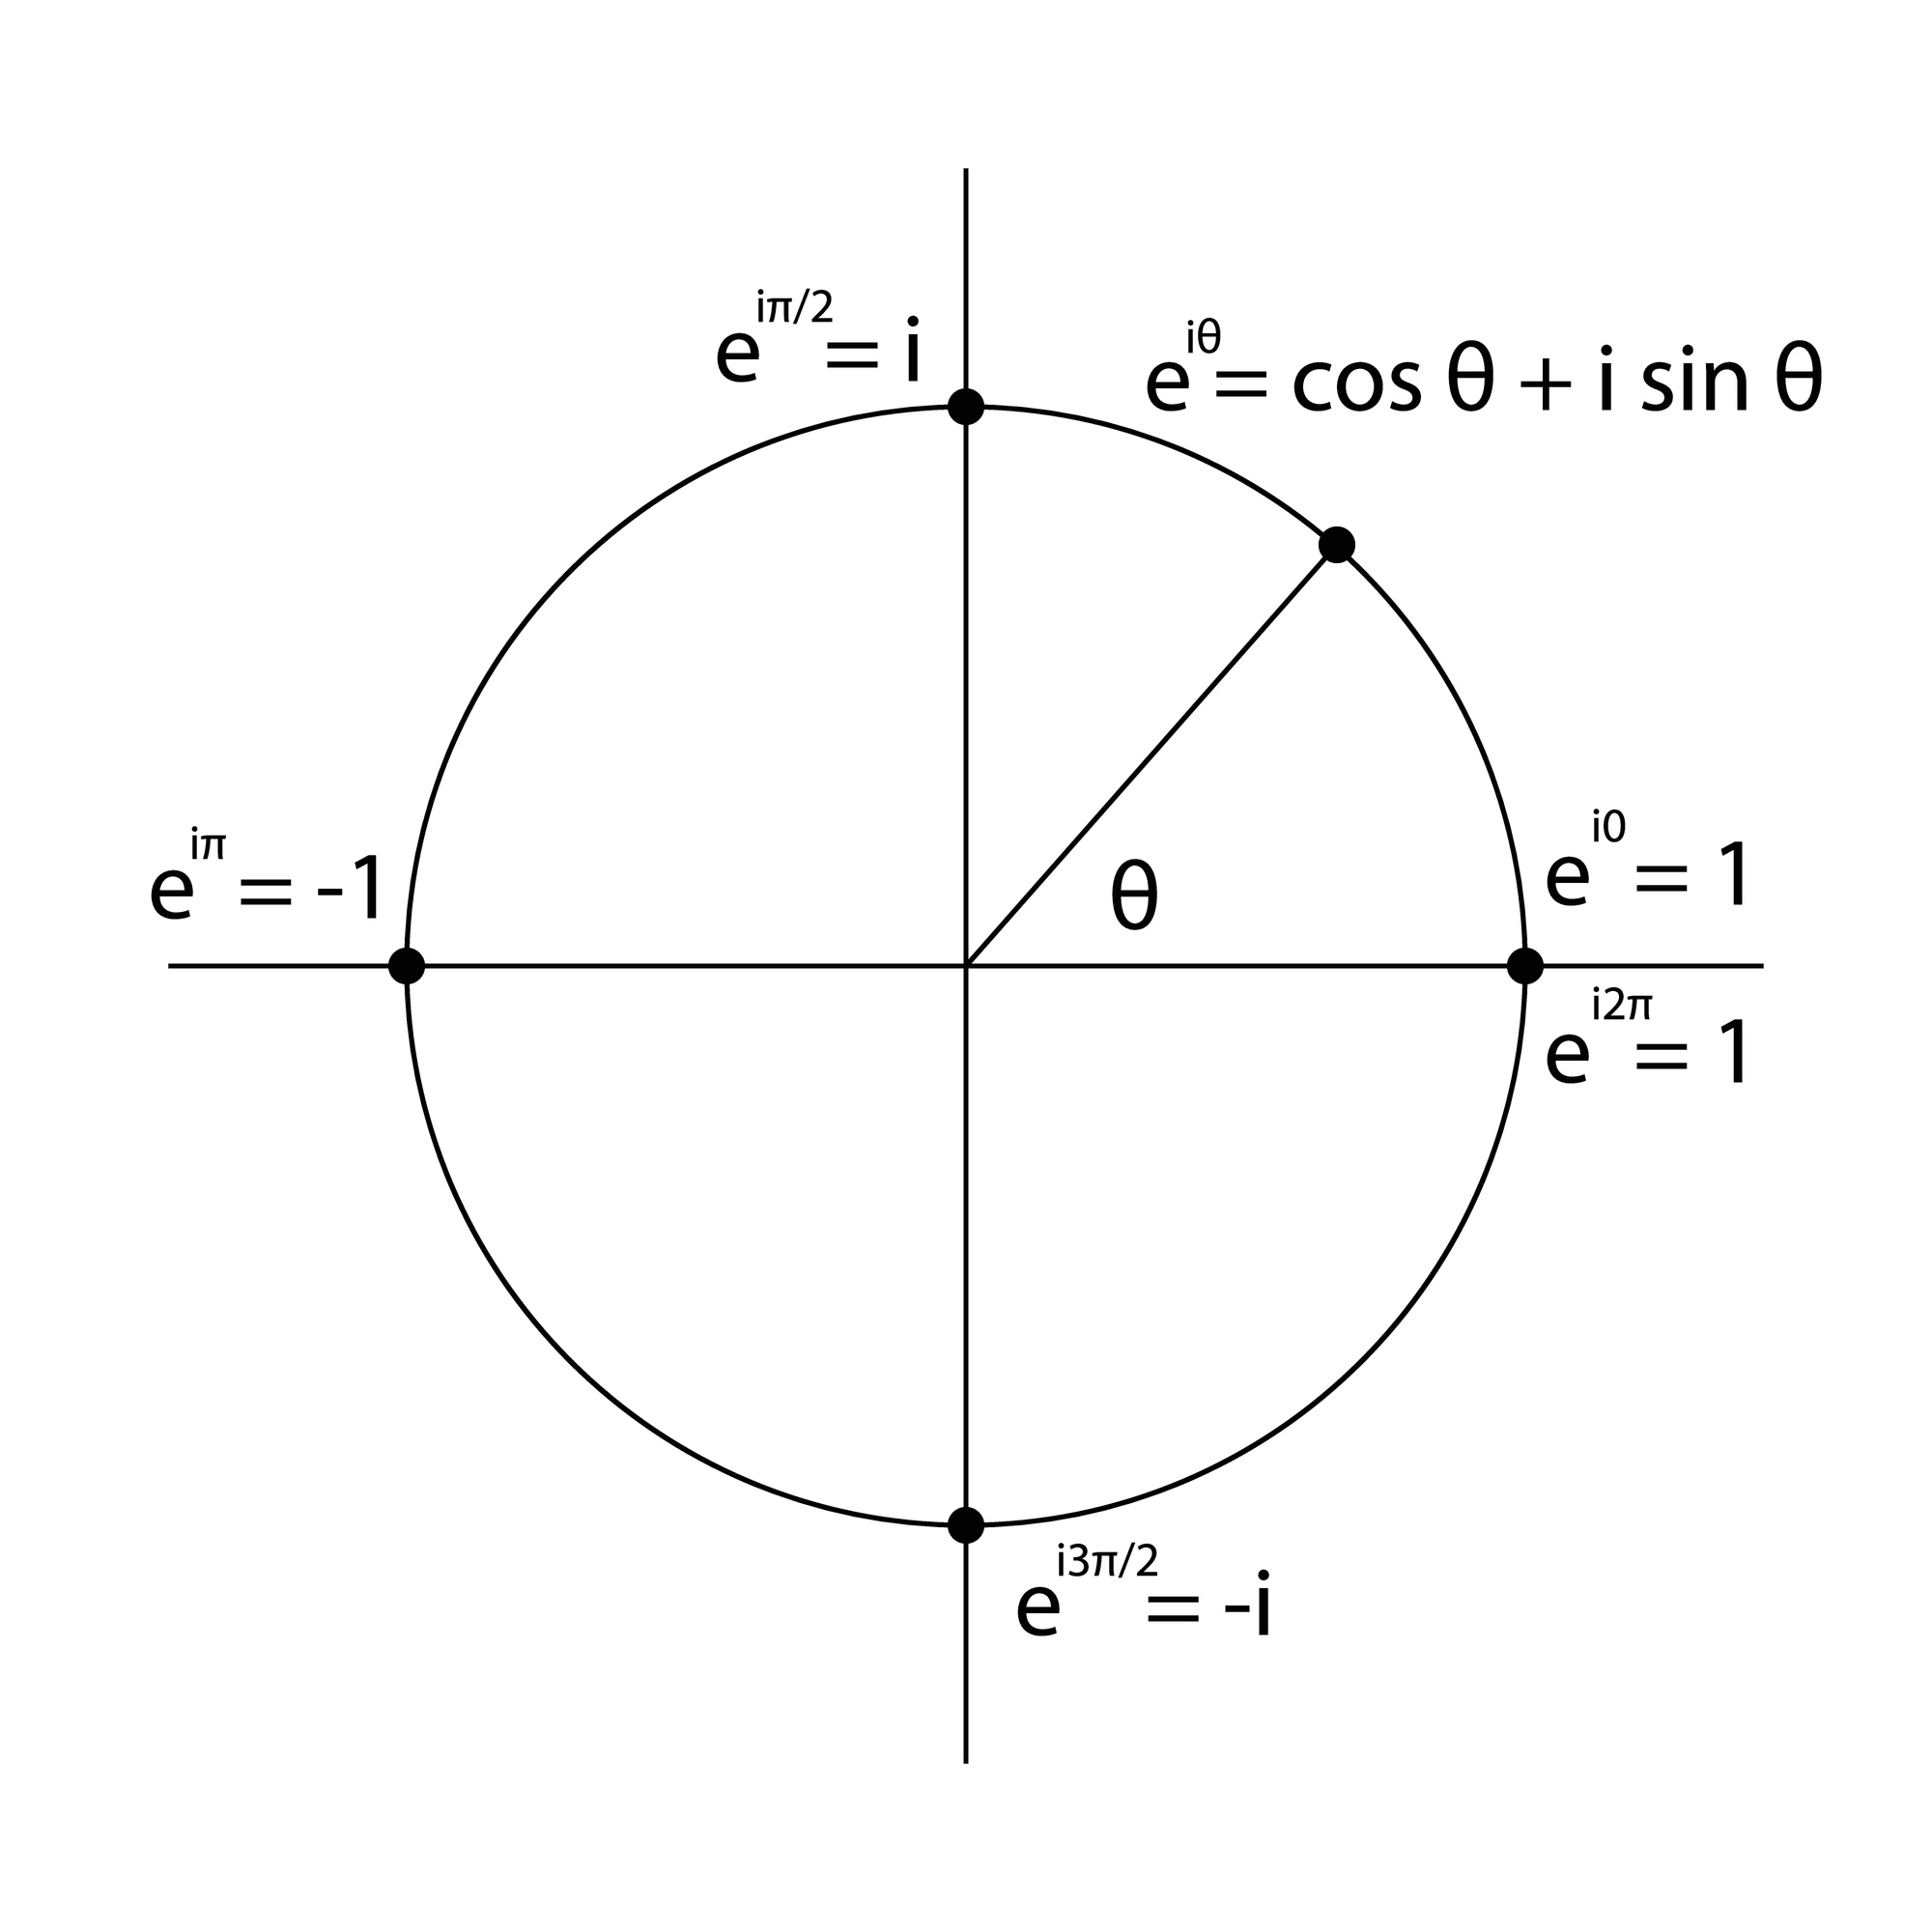

- Solutions : 
> - Convert the time to the 24 hours 
>   - Problem : even the 11 at night is near the 00:00 in the morning , the model will think they are far apart 

- Better Solutions : 
> - Use the Sin and cos for the transformations (see above)

In [14]:
# Create a new feature 'hour_of_day'
# step % 24 gives the remainder when dividing by 24
# step 1 -> 1 % 24 = 1 (1:00 AM)
# step 25 -> 25 % 24 = 1 (1:00 AM)
# step 48 -> 48 % 24 = 0 (Midnight)
df['hour_of_day'] = df['step'] % 24

In [15]:
import numpy as np

# 'hour_of_day' is the column we created in step 1
hours_in_day = 24

# Create the 'hour_sin' feature
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / hours_in_day)

# Create the 'hour_cos' feature
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / hours_in_day)

df.drop(columns=["hour_of_day","step"],inplace=True)
df.head()

,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,hour_sin,hour_cos
0,PAYMENT,9839.64,C,M,0,0,0.258819,0.965926
1,PAYMENT,1864.28,C,M,0,0,0.258819,0.965926
2,TRANSFER,181.00,C,C,1,0,0.258819,0.965926
3,CASH_OUT,181.00,C,C,1,0,0.258819,0.965926
4,PAYMENT,11668.14,C,M,0,0,0.258819,0.965926


In [16]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [17]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Observations 
- Data imbalance 
- might give some patterns about the type of transaction being fraud 
- isFlaggedFraud is based on simple business logic (> 200000) -> This could help in making a better model 
> - How ?? 
>   - if it shows correlation with transaction being fraud -> it might just mean that we jsut need to update the numbers to improve the accuracy (not likely - but maybe )
>   - If it does not show anythign this must be removed 

In [18]:
# Let's See how kind of transaction affect the fraud 
print(df.groupby('type')['isFraud'].sum())

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [19]:
# Lets see how effective the business rule is about finding the fraud Transaction
pd.crosstab(df['isFlaggedFraud'], df['isFraud'])

isFraud,0,1
isFlaggedFraud,,
0,6354407,8197
1,0,16


# Observations 
- It is evident that all the frauds are either in the CASH_OUT or TRANSFER type of transactions 
- It is also evident that the simple business logic that flags everything above 200000 as fraud is definitely not working as it misses 8197 instances 

# Plots

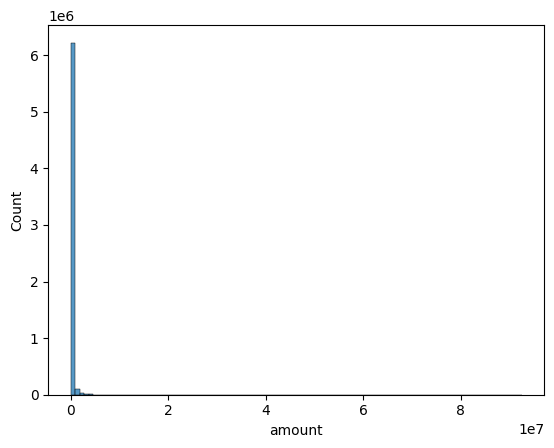

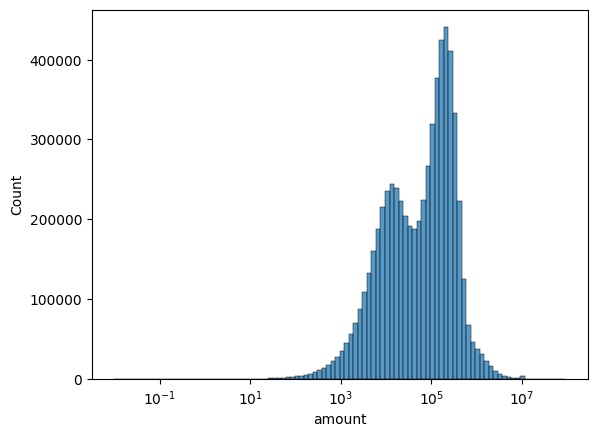

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# This will look squished, showing the skew
sns.histplot(df['amount'], bins=100)
plt.show()

# A log scale plot is much more useful
sns.histplot(df['amount'], bins=100, log_scale=True)
plt.show()

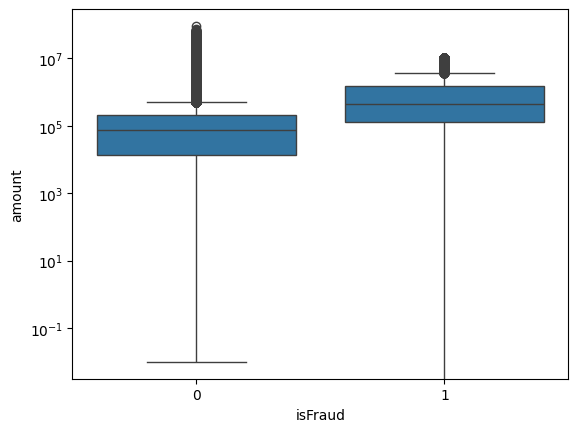

Non-Fraud Stats:
 count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

Fraud Stats:
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64


In [ ]:
# Use a log scale on the y-axis to make it readable
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log') # Use log scale!
plt.show()

# Also check the descriptive statistics
print("Non-Fraud Stats:\n", df[df['isFraud'] == 0]['amount'].describe())
print("\nFraud Stats:\n", df[df['isFraud'] == 1]['amount'].describe())

c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


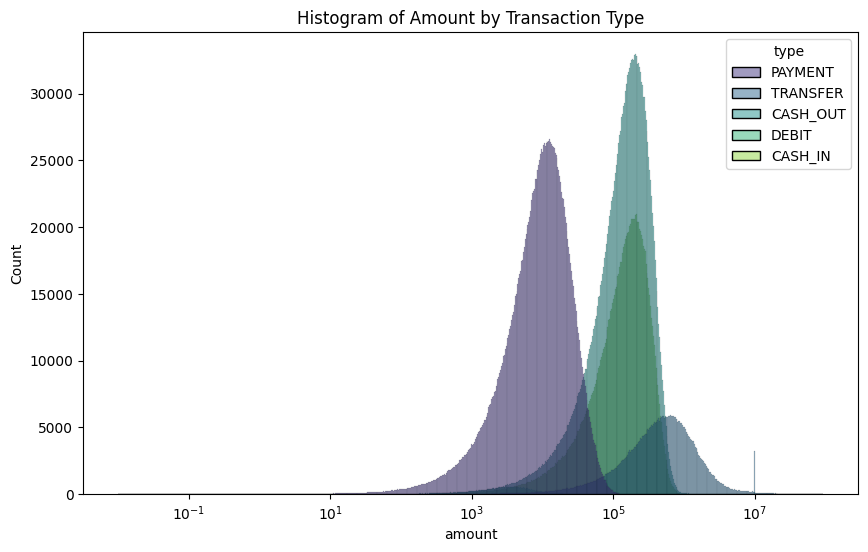

c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


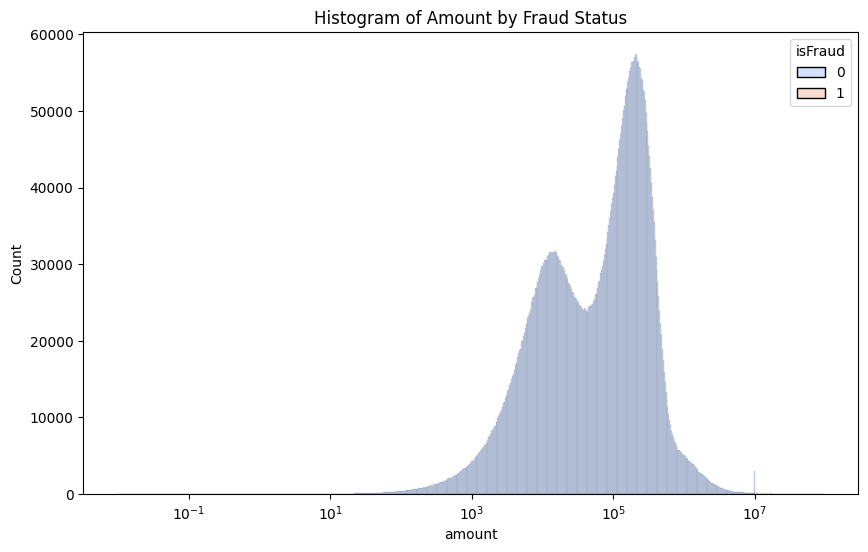

c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\parsh\OneDrive\Desktop\DSc_Project\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


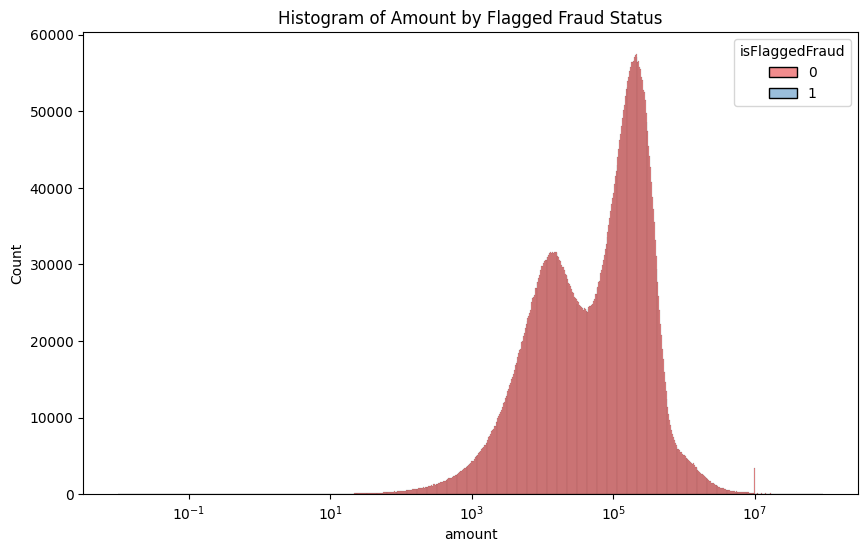

In [42]:
# Test the 'type' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='type', kde=True, log_scale=True, palette='viridis') # Added palette
plt.title('Histogram of Amount by Transaction Type')
plt.show()

# Test the 'isFraud' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='isFraud', kde=True, log_scale=True, palette='coolwarm') # Different palette
plt.title('Histogram of Amount by Fraud Status')
plt.show()

# Test the 'isFlaggedFraud' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='isFlaggedFraud', kde=True, log_scale=True, palette='Set1') # Another palette
plt.title('Histogram of Amount by Flagged Fraud Status')
plt.show()

# Hypothesis Testing

### Independent sample t-test
* Null Hypothesis (H0): 
  The mean transaction amount for fraudulent and non-fraudulent transactions is the same.
* Alternative Hypothesis (H1)
   The mean transaction amount for fraudulent and non-fraudulent transactions is different.

* We require normalizing our dataset here due to presence of skewness on one side

In [35]:
import numpy as np


df['log_amount'] = np.log1p(df['amount'])  


In [29]:
fraud_log = df[df['isFraud'] == 1]['log_amount']
nonfraud_log = df[df['isFraud'] == 0]['log_amount']


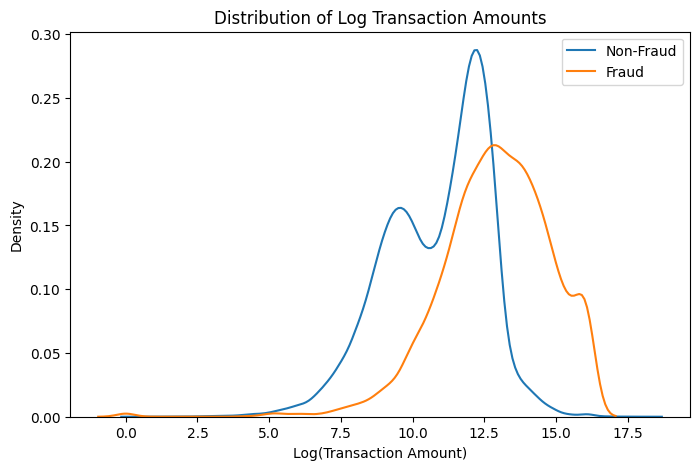

In [39]:
plt.figure(figsize=(8,5))
sns.kdeplot(nonfraud_log.sample(50000, random_state=42), label='Non-Fraud')
sns.kdeplot(fraud_log, label='Fraud')
plt.title('Distribution of Log Transaction Amounts')
plt.xlabel('Log(Transaction Amount)')
plt.ylabel('Density')
plt.legend()
plt.show()


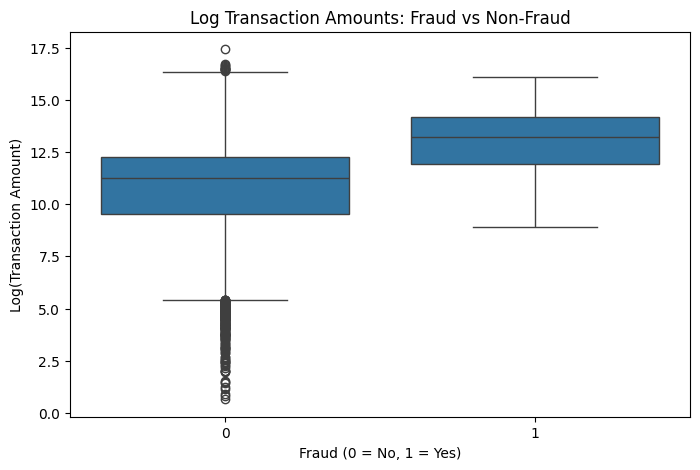

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='log_amount', data=df.sample(50000, random_state=42))
plt.title('Log Transaction Amounts: Fraud vs Non-Fraud')
plt.xlabel('Fraud (0 = No, 1 = Yes)')
plt.ylabel('Log(Transaction Amount)')
plt.show()


In [41]:
import scipy.stats as stats

t_stat, p_val = stats.ttest_ind(fraud_log, nonfraud_log, equal_var=False)
print(f"T-statistic: {t_stat:.4f},  p-value: {p_val:.4e}")


T-statistic: 95.7571,  p-value: 0.0000e+00


### Interpretation
* t-statistic measures the difference between the means of the two groups relative to the variation in the data, and with such high t-value, difference between fraud and non-fraud transaction amounts is huge relative to their spread
* p-value is probability of observing a difference as extreme as this if the null hypothesis were true. Thus we will strongly reject null hypothesis
#### This means 
* There is a statistically significant difference in transaction amounts (after log transformation) between fraudulent and non-fraudulent transactions.

## Secondary Tests
### Chi-Square Test
* Null Hypothesis -> Fraud occurrence is independent of transaction type.
* Alternate Hypothesis -> Fraud occurrence depends on transaction type.

In [ ]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['type'], df['isFraud'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-stat : {chi2}")
print(f"p-value : {p}")

Chi-stat : 22082.53571319108
p-value : 0.0


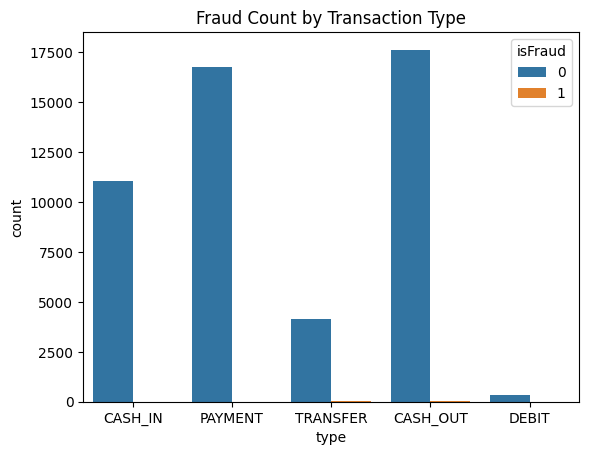

In [ ]:
sns.countplot(x='type', hue='isFraud', data=df.sample(50000, random_state=42))
plt.title('Fraud Count by Transaction Type')
plt.show()

#### Interpretation
* p < 0.05, we will reject the null hypothesis

# One-Hot Encoding

In [ ]:
df_categorical = df.copy()

df_model = df.drop(columns=['nameOrig', 'nameDest'])

df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

df_model.head()


,amount,isFraud,isFlaggedFraud,hour_sin,hour_cos,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,0,0,0.258819,0.965926,False,False,True,False
1,1864.28,0,0,0.258819,0.965926,False,False,True,False
2,181.00,1,0,0.258819,0.965926,False,False,False,True
3,181.00,1,0,0.258819,0.965926,True,False,False,False
4,11668.14,0,0,0.258819,0.965926,False,False,True,False
